# This notebook reads the FITS File generated by Dsim


In [1]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask
from smdtLibs import utils, drawUtils
from astropy.modeling import models, fitting
from Test_Inputs import Test_Inputs
from DistortionUtil import projectTargetXYs

In [2]:
try:
    %load_ext nb_black
except Exception as e:
    print("Ignore extension nb_black", e)
    pass

<IPython.core.display.Javascript object>

In [3]:
logging.disable()

<IPython.core.display.Javascript object>

## Read the config file and the parameter file

In [4]:
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)

<IPython.core.display.Javascript object>

## The mask layout

In [5]:
layout = MaskLayouts["deimos"]
guiderLayout = GuiderFOVs["deimos"]

<IPython.core.display.Javascript object>

# Select Input file

In [6]:
FileName, input_RA, input_DEC, fieldPA, slit_PA, flag = Test_Inputs[
    "denseOverlappingPa90Mask"
]

<IPython.core.display.Javascript object>

In [7]:
mdf = MaskDesignInputFitsFile(FileName)

<IPython.core.display.Javascript object>

### Define the coordinates of the center

The center (RA/DEC) is defined in the input target list, first row.

This is different than the pointing coordinates in the FITS file, table maskdesign reference RA/DEC.


In [8]:
cenRA = utils.sexg2Float(input_RA) * 15  # - 22 / 3600
cenDEC = utils.sexg2Float(input_DEC)  # - 5 / 3600

<IPython.core.display.Javascript object>

### Compare Center RA/DEC to Pointing RA/DEC

Center RA/DEC is the one from the CenterLine see above.

Pointing RA/DEC is from the FITS file.
Pointing RA/DEC not used in calculations.

In [9]:
pntCenRa, pntCenDec = mdf.getCenter()  # As stored in the FITS file

print(
    "Pnt Coords \tRA {}, DEC {}\nCenter \t\tRA {}, DEC {}".format(
        utils.toSexagecimal(pntCenRa / 15),
        utils.toSexagecimal(pntCenDec),
        utils.toSexagecimal(cenRA / 15),
        utils.toSexagecimal(cenDEC),
    )
)

dfRA, dfDEC = pntCenRa - cenRA, pntCenDec - cenDEC
cosDec = math.cos(math.radians(cenDEC))
print ("dfRA = {:.2f} dfDE= {:.2f}".format(dfRA * 3600, dfDEC * 3600))


Pnt Coords 	RA  17:18:47.62, DEC  57:53:58.23
Center 		RA  17:18:45.42, DEC  57:58:55.20
dfRA = 32.97 dfDE= -296.97


<IPython.core.display.Javascript object>

In [10]:
useCen = True  # Use input RA/DEC
if useCen:
    pass
else:
    # if we don't have Center RA/DEC, we will use Pnt Coords + 196",-217"
    cenRA = pntCenRa - 196.90 / 3600
    cenDEC = pntCenDec + 217.40 / 3600
    fieldPA = mdf.maskdesign.PA_PNT[0]
print(cenRA, cenDEC, fieldPA)

259.68925 57.982 90.0


<IPython.core.display.Javascript object>

### Check which targets are inside or selected

In [11]:
tlist = mdf.getAsTargets(cenRA, cenDEC, config)  # Gets targets as TargetList object

<IPython.core.display.Javascript object>

In [12]:
tlist.markInside(layout)

<IPython.core.display.Javascript object>

In [13]:
print(len(tlist.targets))

1837


<IPython.core.display.Javascript object>

In [14]:
raHs, decs = np.array([pntCenRa / 15.0, cenRA / 15.0]), np.array([pntCenDec, cenDEC])

# Note: tlist.telRaRad/telDecRad = cenRA/cenDEC
censX, censY = tlist._calcTelTargetCoords(
    tlist.telRaRad, tlist.telDecRad, raHs, decs, tlist.positionAngle
)

#  censX/censY projected positions of the array raHs/decs in the focal plane
labels = "Pointing", "CenerLine"
print(f"{' ':<12s} {'X':>7s}, {'Y':>7s}")
for lb, cx, cy in zip(labels, censX, censY):
    print(f"{lb:<12s} {cx:7.2f}, {cy:7.2f}")

                   X,       Y
Pointing       17.52,  -26.97
CenerLine       0.00,  270.00


<IPython.core.display.Javascript object>

In [15]:
# For testing only
# outputAsList("test.list", tlist.targets)

<IPython.core.display.Javascript object>

## Get shortcuts for inside targets, alignment boxes, guider boxes

In [16]:
allTargetsOrg = tlist.targets
print("len allTargets", len(allTargetsOrg))
allTargets = allTargetsOrg[allTargetsOrg.dSlitId > 0]
print("len allTargets", len(allTargets))

inTargets = allTargets[allTargets.inMask > 0]
selectedTargets = inTargets[np.logical_and(inTargets.pcode > 0, inTargets.selected > 0)]
alignBoxes = allTargets[allTargets.pcode == -2]
guideBoxes = allTargets[allTargets.pcode == -1]

inSelectedTargets = selectedTargets[selectedTargets.inMask > 0]
inAlignBoxes = alignBoxes[alignBoxes.inMask > 0]

len allTargets 1837
len allTargets 1826


<IPython.core.display.Javascript object>

### Plot the mask layout and the targets inside

<IPython.core.display.Javascript object>


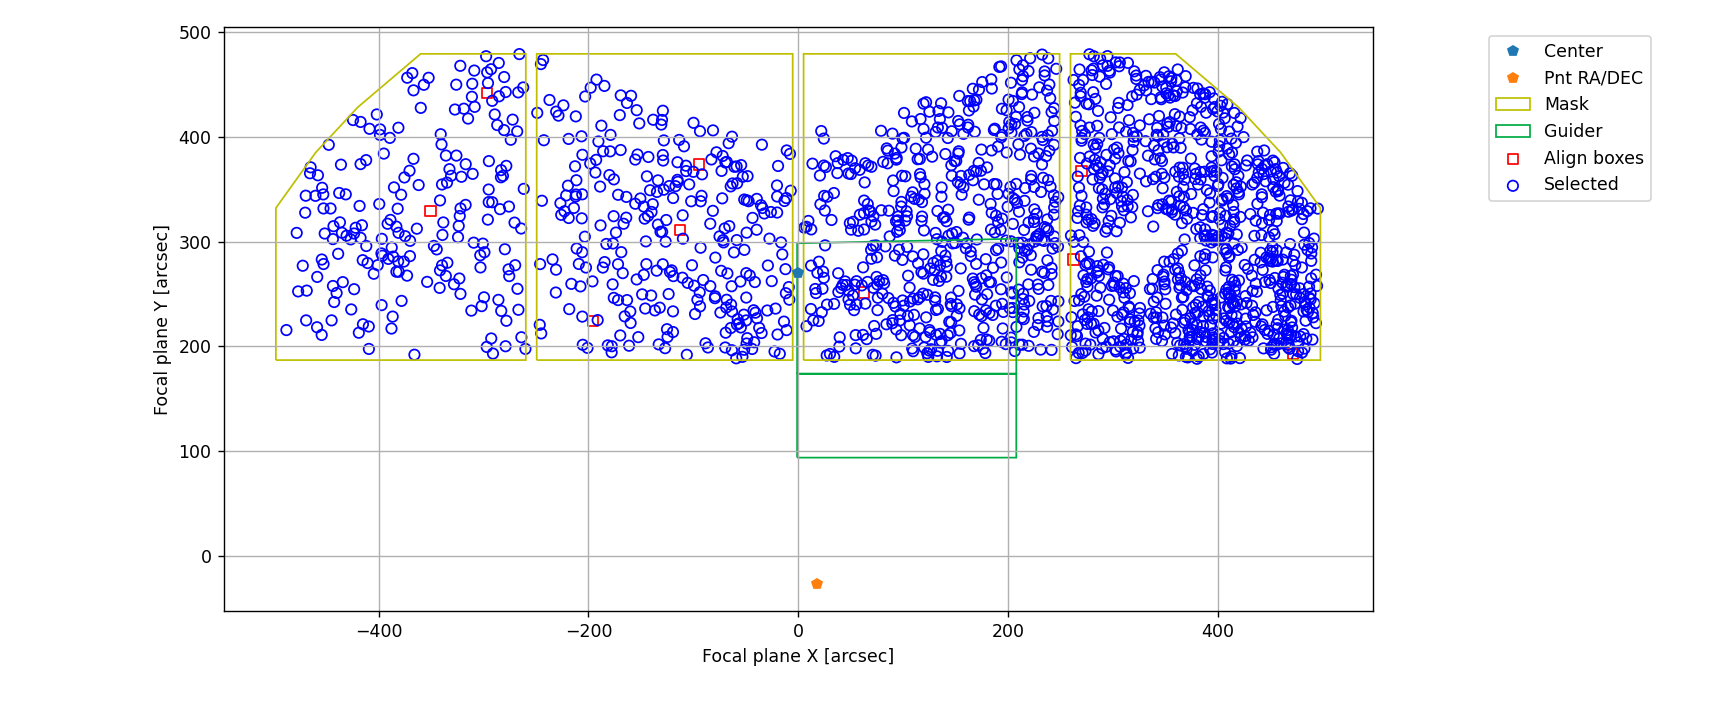

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(11, 4.5))
plt.gca().set_aspect("equal")
p1 = drawUtils.drawPatch(plt.gca(), layout, fc="None", ec="y")
p1.set_label("Mask")
p2 = drawUtils.drawPatch(plt.gca(), guiderLayout, fc="None", ec="#00aa44")
p2.set_label("Guider")

plt.scatter(
    alignBoxes.xarcs,
    alignBoxes.yarcs,
    fc="None",
    ec="r",
    marker="s",
    label="Align boxes",
)

plt.scatter(
    inSelectedTargets.xarcs,
    inSelectedTargets.yarcs,
    fc="None",
    ec="b",
    marker="o",
    label="Selected",
)

plt.xlabel("Focal plane X [arcsec]")
plt.ylabel("Focal plane Y [arcsec]")

plt.plot(censX[1:], censY[1:], "p", label="Center")
plt.plot(censX[:1], censY[:1], "p", label="Pnt RA/DEC")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
plt.grid()
plt.tight_layout()

## The Slits coordinates (from DSIM FITS file)
### Conversion from mm to arcsec

The slits coordinates are given in mm, so we convert them to arcsec.

In [18]:
targetOnSlitX, targetOnSlitY, slitXYs = projectTargetXYs(inTargets)

<IPython.core.display.Javascript object>

## Calculate slits coordinates using target coordinates, no distortion compensation


In [19]:
#
# Get slit length and width from configuration
#
slitLen = config.params.minslitlength[0]
slitWidth = config.params.slitwidth[0]
slitWidth = 0.7
slitHalf = slitLen / 2
slitHWidth = slitWidth / 2

wantSlitXYs = []  # Stores slits coordinates in arcsec

print(f"Calculate slit positions, slit width = {slitWidth}")
indices = ["xarcs", "yarcs", "TopDist", "BotDist"]

for i, (sx, sy, top, bot) in selectedTargets[indices].iterrows():
    # print ("{} {:.1f} {} {}".format(i, sx, top, bot))

    # Top-left
    x0 = sx - top
    y0 = sy - slitHWidth

    # bottom-left
    x1 = sx + bot
    y1 = sy - slitHWidth

    # bottom-right
    x2 = sx + bot
    y2 = sy + slitHWidth

    # top-right
    x3 = sx - top
    y3 = sy + slitHWidth

    wantSlitXYs.append((x0, y0, 0))
    wantSlitXYs.append((x1, y1, 1))
    wantSlitXYs.append((x2, y2, 1))
    wantSlitXYs.append((x3, y3, 1))
    wantSlitXYs.append((x0, y0, 2))

Calculate slit positions, slit width = 0.7


<IPython.core.display.Javascript object>

## Compare DSIM slits coordinates and calculated slits coordinates

### Plot the slits and the mask in arcsec

<IPython.core.display.Javascript object>


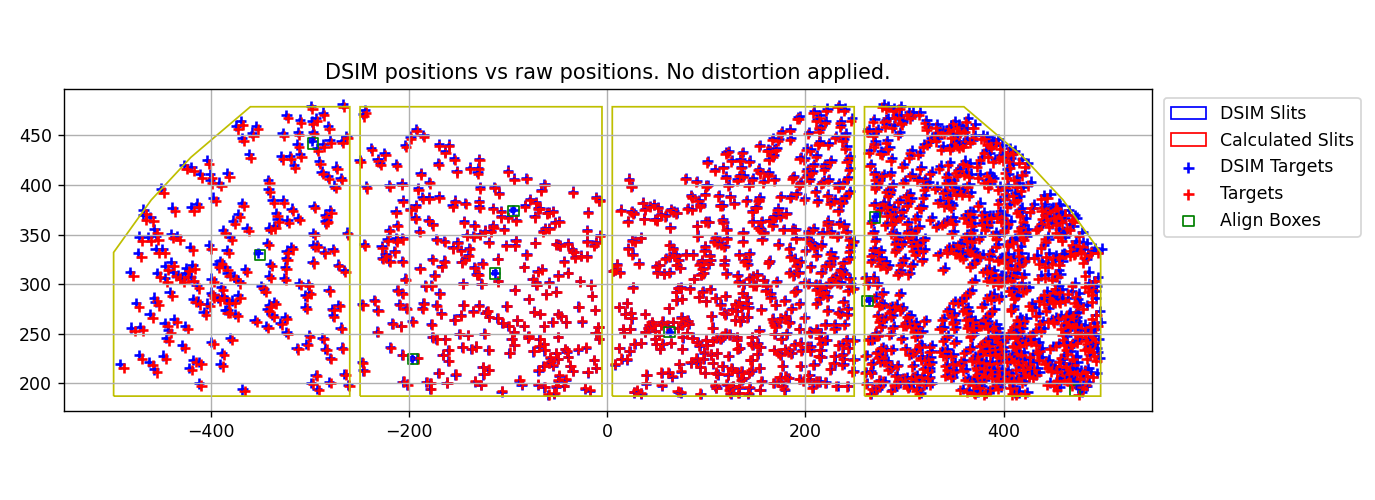

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(11, 4))
plt.gca().set_aspect("equal")

plt.title("DSIM positions vs raw positions. No distortion applied.")
# Plot the slits (from FITS file)
p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label("DSIM Slits")
plt.scatter(
    targetOnSlitX, targetOnSlitY, fc="None", ec="b", marker="+", label="DSIM Targets"
)


# Plot the calculated slit position
p1 = drawUtils.drawPatch(plt.gca(), wantSlitXYs, fc="None", ec="r")
p1.set_label("Calculated Slits")
# Plot the selected targets
plt.scatter(
    selectedTargets.xarcs,
    selectedTargets.yarcs,
    fc="None",
    ec="r",
    marker="+",
    label="Targets",
)

# Plot the mask layout
drawUtils.drawPatch(plt.gca(), layout, offx=0, offy=0, fc="None", ec="y")

# Plot the alignment boxes
plt.scatter(
    alignBoxes.xarcs,
    alignBoxes.yarcs,
    fc="None",
    ec="g",
    marker="s",
    label="Align Boxes",
)
# Legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc="upper right")
# plt.plot(xarcs1, yarcs1, "^", label="alternative")
plt.grid()
plt.tight_layout()

## Calculate field projection
### How to match DSIM coordinates?

In [21]:
#
# Calculate the differences in X and Y
#
dx = targetOnSlitX - inTargets.xarcs
dy = targetOnSlitY - inTargets.yarcs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


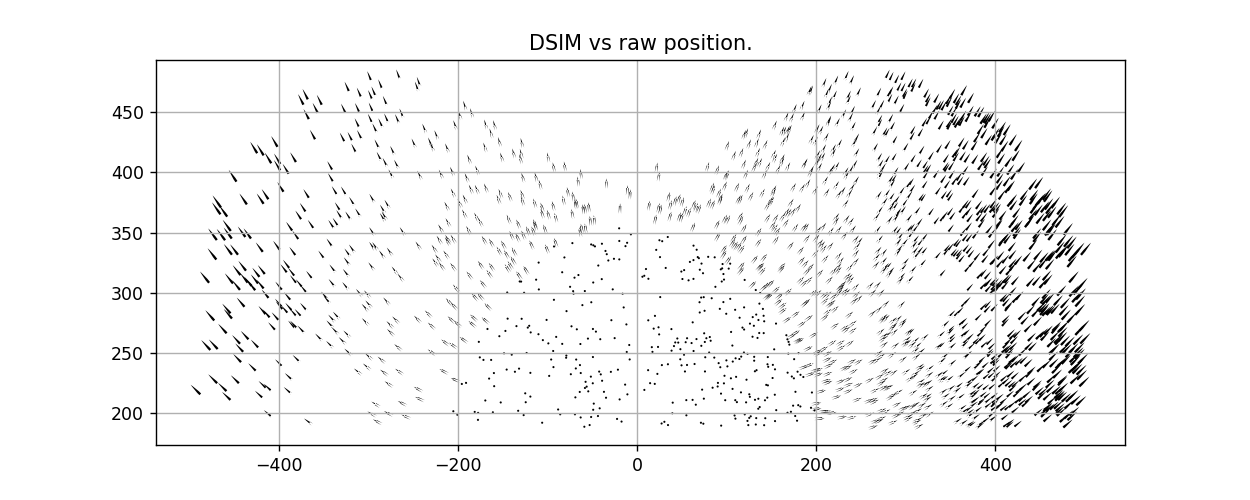

<IPython.core.display.Javascript object>

In [22]:
#
# Plot the difference between projected and original
#
plt.figure(figsize=(10, 4))
plt.title("DSIM vs raw position.")
plt.gca().quiver(
    inTargets.xarcs,
    inTargets.yarcs,
    dx,
    dy,
    scale=0.4,
    scale_units="xy",
    headwidth=0.3,
    headlength=1,
)
plt.grid()

In [23]:
#
# Fit the 4th deg 2D polynomial function to map from original to calculated.
#
pdeg = 4
xModel = models.Polynomial2D(degree=pdeg)
xfitter = fitting.LinearLSQFitter ()
xfitted = xfitter (xModel, inTargets.xarcs, inTargets.yarcs, targetOnSlitX)

yModel = models.Polynomial2D(degree=pdeg)
yfitter = fitting.LinearLSQFitter ()
yfitted = yfitter (yModel, inTargets.xarcs, inTargets.yarcs, targetOnSlitY)


<IPython.core.display.Javascript object>

In [24]:
projectedX = xfitted(allTargets.xarcs, allTargets.yarcs)
projectedY = yfitted(allTargets.xarcs, allTargets.yarcs)

alignProjX = xfitted(alignBoxes.xarcs, alignBoxes.yarcs)
alignProjY = yfitted(alignBoxes.xarcs, alignBoxes.yarcs)

#
# Calculate projected slits
#

projSlitXYs = []  #

print(f"Calculate projected slit positions, slit width = {slitWidth}")
indices = ["xarcs", "yarcs", "TopDist", "BotDist", "slitLPA"]


def proj(x, y):
    return xfitted(x, y), yfitted(x, y)


for i, (sx, sy, top0, bot0, slitLPA) in selectedTargets[indices].iterrows():
    # print ("{} {:.1f} {} {}".format(i, sx, top, bot))

    rotAngle = np.radians(slitLPA - fieldPA)
    sinA = np.sin(rotAngle)
    cosA = np.cos(rotAngle)

    leftx = cosA * top0
    lefty = sinA * top0
    rightx = cosA * bot0
    righty = sinA * bot0

    # bottom-left
    x0 = sx - leftx
    y0 = sy + lefty
    x0, y0 = proj(x0, y0)
    y0 -= slitHWidth

    # bottom-right
    x1 = sx + rightx
    y1 = sy - righty
    x1, y1 = proj(x1, y1)
    y1 -= slitHWidth

    # top-right
    x2 = sx + rightx
    y2 = sy - righty
    x2, y2 = proj(x2, y2)
    y2 += slitHWidth

    # top-left
    x3 = sx - leftx
    y3 = sy + lefty
    x3, y3 = proj(x3, y3)
    y3 += slitHWidth

    projSlitXYs.append((x0, y0, 0))
    projSlitXYs.append((x1, y1, 1))
    projSlitXYs.append((x2, y2, 1))
    projSlitXYs.append((x3, y3, 1))
    projSlitXYs.append((x0, y0, 2))

Calculate projected slit positions, slit width = 0.7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


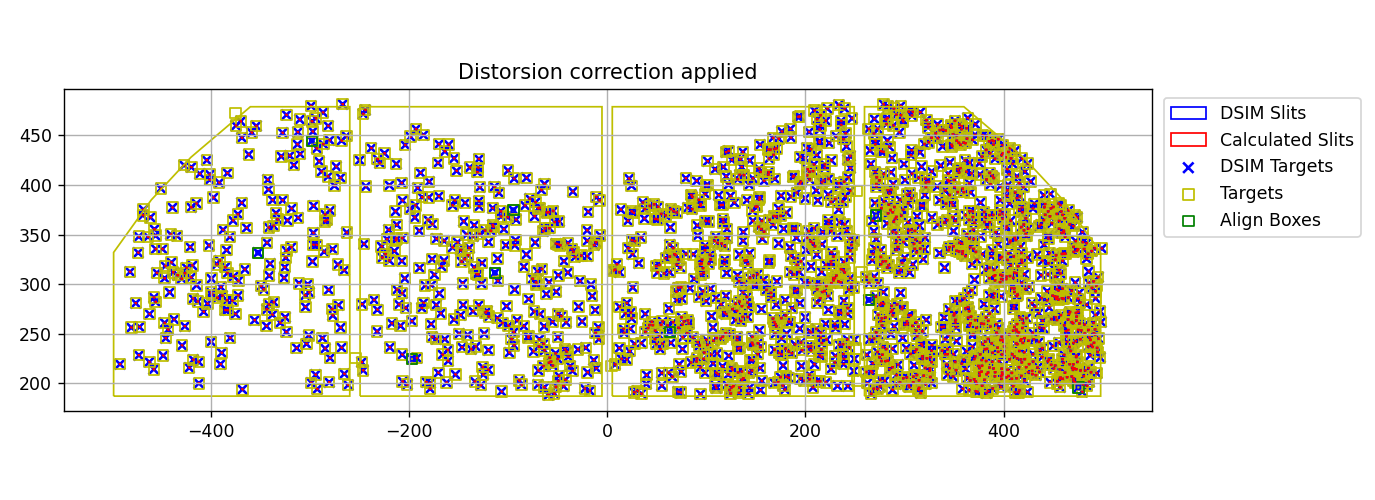

<IPython.core.display.Javascript object>

In [25]:
#
# Plot the coordinates using the fitted model
#
plt.figure(figsize=(11, 4))
plt.gca().set_aspect("equal")
plt.title("Distorsion correction applied")
# Plot the slits (from FITS file)
p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label("DSIM Slits")
plt.scatter(
    targetOnSlitX, targetOnSlitY, fc="None", ec="b", marker="x", label="DSIM Targets"
)

# Plot the calculated slit position
p1 = drawUtils.drawPatch(plt.gca(), projSlitXYs, fc="None", ec="r")
p1.set_label("Calculated Slits")
# Plot the selected targets
plt.scatter(
    projectedX,
    projectedY,
    fc="None",
    ec="y",
    marker="s",
    label="Targets",
)

# Plot the mask layout
drawUtils.drawPatch(plt.gca(), layout, offx=0, offy=0, fc="None", ec="y")

# Plot the alignment boxes
plt.scatter(
    alignProjX,
    alignProjY,
    fc="None",
    ec="g",
    marker="s",
    label="Align Boxes",
)
# Legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc="upper right")
plt.grid()
plt.tight_layout()

In [27]:
with np.printoptions(precision=6, suppress=True):
    print(xfitted.parameters)
    print(yfitted.parameters)

[ 0.015107  1.005084 -0.        0.        0.        0.000249 -0.
  0.        0.       -0.000004  0.       -0.        0.       -0.
 -0.      ]
[-2.548532 -0.000074  0.000018  0.        0.        1.010583 -0.000004
  0.       -0.        0.       -0.        0.       -0.        0.
 -0.      ]


<IPython.core.display.Javascript object>